In [2]:
import sys
print(sys.executable)
print(sys.path)

/Users/chenxi/my_env_3.9/bin/python
['/Users/chenxi/developer/root/root-6.32.00-install/lib', '/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/chenxi/my_env_3.9/lib/python3.9/site-packages']


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle, Circle, Wedge
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import erf
from scipy.optimize import minimize
from numpy.random import default_rng
rng = default_rng()

In [11]:
class DetectorParams:
    """All detector and electronics parameters in one place"""
    
    # Gas properties / drift
    D_T = 175.0              # μm/√cm - transverse diffusion coefficient
    D_L = 230.0              # μm/√cm - longitudinal diffusion coefficient  
    v_drift = 8.0            # cm/μs = 0.008 mm/ns - drift velocity
    TPC_length = 200.0       # cm - TPC drift length (cathode to readout)
    
    # Avalanche intrinsic spreads (GEM/Micromegas)
    sigma_aval_r = 0.10      # mm - transverse spread from avalanche
    sigma_aval_t = 2.0       # ns - temporal spread from avalanche
    
    # Gain parameters
    gain_mean = 5000         # Average avalanche gain
    polya_theta = 0.5        # Polya parameter (0.5-1.0 typical)
    
    # Electronics shaping (CR-RC with n=1)
    tau_shaper = 100.0       # ns - shaping time constant
    
    # Digitization
    adc_dt = 50.0            # ns - ADC sampling period
    window_ns = 5000.0       # ns - total readout window
    adc_bits = 12            # ADC bit depth
    adc_conversion = 0.1     # mV per electron (after gain)
    adc_noise = 5.0          # ADC counts RMS noise
    adc_threshold = 10.0     # ADC threshold
    
    # Pad geometry
    pad_geometry = 'rectangular'  # 'rectangular' or 'rphi'
    
    # For rectangular pads
    pad_width_mm = 4.0       # mm - pad width in x
    pad_height_mm = 4.0      # mm - pad height in y
    
    # For r-φ pads  
    pad_r_mm = 4.0           # mm - pad radial size
    pad_phi_mrad = 10.0      # mrad - pad angular size (at reference radius)
    r_reference = 100.0      # mm - reference radius for phi calculation
    
    # Coverage
    n_sigma_pad = 3 

In [12]:
# Global derived values
P = DetectorParams()
NT = int(P.window_ns // P.adc_dt)
BIN_EDGES = np.arange(NT + 1) * P.adc_dt  
BIN_CENTERS = 0.5 * (BIN_EDGES[:-1] + BIN_EDGES[1:])

In [13]:
# Pre-compute shaper kernel
def compute_shaper_kernel():
    """CR-RC semi-Gaussian response, normalized to unit area"""
    t = BIN_CENTERS
    h = (t / P.tau_shaper**2) * np.exp(-t / P.tau_shaper)
    h[t < 0] = 0
    # Normalize
    h = h / (np.sum(h) * P.adc_dt)
    return h

In [14]:
SHAPER_KERNEL = compute_shaper_kernel()

In [15]:
def gaussian_integral_1d(a, b, mu, sigma):
    """Analytic integral of 1D Gaussian from a to b"""
    if sigma <= 0:
        return 0.0
    return 0.5 * (erf((b - mu) / (np.sqrt(2) * sigma)) - 
                  erf((a - mu) / (np.sqrt(2) * sigma)))

In [16]:
def calculate_cloud_parameters(z0_cm):
    """
    Calculate expected cloud parameters from drift distance
    Combines drift diffusion with avalanche spread
    """
    # Drift distance
    dz_cm = abs(z0_cm - P.TPC_length)
    
    # Drift diffusion spreads
    sigma_drift_r_mm = P.D_T * np.sqrt(dz_cm) / 1000.0  # μm to mm
    sigma_drift_t_ns = (P.D_L * np.sqrt(dz_cm) / 1e4) / P.v_drift * 1000  # to ns
    
    # Combine with avalanche spreads (add in quadrature)
    sigma_r_total = np.hypot(sigma_drift_r_mm, P.sigma_aval_r)
    sigma_t_total = np.hypot(sigma_drift_t_ns, P.sigma_aval_t)
    
    # Mean drift time
    t_drift_us = dz_cm / P.v_drift
    t_drift_ns = t_drift_us * 1000
    
    return {
        'dz_cm': dz_cm,
        'sigma_drift_r': sigma_drift_r_mm,
        'sigma_drift_t': sigma_drift_t_ns,
        'sigma_total_r': sigma_r_total,
        'sigma_total_t': sigma_t_total,
        't_drift_ns': t_drift_ns
    }

In [17]:
def get_rectangular_pads(x0_mm, y0_mm, sigma_r):
    """Find rectangular pads hit by electron cloud and calculate charge fractions"""
    pad_fractions = {}
    
    # Range to check
    R = P.n_sigma_pad * sigma_r + max(P.pad_width_mm, P.pad_height_mm)
    
    # Pad indices to check
    i_min = int(np.floor((x0_mm - R) / P.pad_width_mm))
    i_max = int(np.floor((x0_mm + R) / P.pad_width_mm))
    j_min = int(np.floor((y0_mm - R) / P.pad_height_mm))
    j_max = int(np.floor((y0_mm + R) / P.pad_height_mm))
    
    for i in range(i_min, i_max + 1):
        for j in range(j_min, j_max + 1):
            # Pad boundaries
            x_min = i * P.pad_width_mm
            x_max = (i + 1) * P.pad_width_mm
            y_min = j * P.pad_height_mm
            y_max = (j + 1) * P.pad_height_mm
            
            # Integrate 2D Gaussian over pad
            frac_x = gaussian_integral_1d(x_min, x_max, x0_mm, sigma_r)
            frac_y = gaussian_integral_1d(y_min, y_max, y0_mm, sigma_r)
            frac = frac_x * frac_y
            
            if frac > 1e-8:  # Threshold for significance
                pad_fractions[(i, j)] = frac
                
    return pad_fractions

In [18]:
def get_rphi_pads(x0_mm, y0_mm, sigma_r):
    """Find r-φ pads hit by electron cloud and calculate charge fractions"""
    pad_fractions = {}
    
    # Convert to polar
    r0 = np.sqrt(x0_mm**2 + y0_mm**2)
    phi0 = np.arctan2(y0_mm, x0_mm)
    
    # Simplified: treat as rectangular in (r,φ) space locally
    # This is approximate but good enough for small pads
    
    # Range in r
    r_min = r0 - P.n_sigma_pad * sigma_r
    r_max = r0 + P.n_sigma_pad * sigma_r
    
    # Pad indices in r
    ir_min = int(np.floor(r_min / P.pad_r_mm))
    ir_max = int(np.floor(r_max / P.pad_r_mm))
    
    for ir in range(max(0, ir_min), ir_max + 1):
        # Radial boundaries
        r_pad_min = ir * P.pad_r_mm
        r_pad_max = (ir + 1) * P.pad_r_mm
        r_pad_center = 0.5 * (r_pad_min + r_pad_max)
        
        # Angular size at this radius
        dphi_pad = P.pad_phi_mrad / 1000.0  # mrad to rad
        
        # Range in phi
        dphi_range = P.n_sigma_pad * sigma_r / r_pad_center
        n_phi = int(dphi_range / dphi_pad) + 1
        
        for iphi in range(-n_phi, n_phi + 1):
            phi_pad = phi0 + iphi * dphi_pad
            
            # Approximate pad center
            x_pad = r_pad_center * np.cos(phi_pad)
            y_pad = r_pad_center * np.sin(phi_pad)
            
            # Distance from electron to pad center
            dist = np.sqrt((x_pad - x0_mm)**2 + (y_pad - y0_mm)**2)
            
            # Approximate charge fraction (treating pad as point for simplicity)
            # For production code, do proper 2D integral
            frac = np.exp(-dist**2 / (2 * sigma_r**2)) * P.pad_r_mm * r_pad_center * dphi_pad / (2 * np.pi * sigma_r**2)
            
            if frac > 1e-8:
                pad_fractions[(ir, iphi)] = frac
                
    # Normalize (should sum to ~1)
    total = sum(pad_fractions.values())
    if total > 0:
        pad_fractions = {k: v/total for k, v in pad_fractions.items()}
        
    return pad_fractions

In [19]:
def get_pad_fractions(x0_mm, y0_mm, sigma_r):
    """Wrapper to use appropriate pad geometry"""
    if P.pad_geometry == 'rectangular':
        return get_rectangular_pads(x0_mm, y0_mm, sigma_r)
    else:
        return get_rphi_pads(x0_mm, y0_mm, sigma_r)

In [20]:
def build_serf(x0_cm, y0_cm, z0_cm, return_components=False):
    """
    Build deterministic Single Electron Response Function
    
    Args:
        x0_cm, y0_cm, z0_cm: Initial electron position in cm
        return_components: If True, return intermediate arrays
        
    Returns:
        serf: Dict of pad_id -> time response array
        params: Dict of derived parameters
        components: (optional) Dict with intermediate arrays
    """
    # Convert to mm
    x0_mm = x0_cm * 10
    y0_mm = y0_cm * 10
    
    # Calculate cloud parameters
    cloud_params = calculate_cloud_parameters(z0_cm)
    
    # Get pad charge fractions
    pad_fractions = get_pad_fractions(x0_mm, y0_mm, cloud_params['sigma_total_r'])
    
    # Time distribution (before shaping)
    time_fractions = np.zeros(NT)
    for k in range(NT):
        time_fractions[k] = gaussian_integral_1d(
            BIN_EDGES[k], BIN_EDGES[k+1], 
            cloud_params['t_drift_ns'], 
            cloud_params['sigma_total_t']
        )
    
    # Apply shaping
    shaped_response = np.convolve(time_fractions, SHAPER_KERNEL, mode='full')[:NT]
    
    # Normalize to preserve total charge
    if np.sum(shaped_response) > 0:
        shaped_response = shaped_response / np.sum(shaped_response)
    
    # Build SERF: each pad gets its fraction of the time response
    serf = {}
    for pad_id, frac in pad_fractions.items():
        serf[pad_id] = frac * shaped_response
    
    # Prepare return values
    params = {
        **cloud_params,
        'x0_mm': x0_mm,
        'y0_mm': y0_mm,
        'n_pads': len(pad_fractions)
    }
    
    if return_components:
        components = {
            'pad_fractions': pad_fractions,
            'time_fractions': time_fractions,
            'shaped_response': shaped_response
        }
        return serf, params, components
    else:
        return serf, params

In [21]:
def polya_gain(mean=P.gain_mean, theta=P.polya_theta):
    """Sample from Polya distribution for realistic gain fluctuations"""
    return rng.gamma(shape=theta, scale=mean/theta)

In [22]:
def digitize_serf(serf, gain=None, add_noise=True):
    """
    Convert SERF to digitized ADC values
    
    Args:
        serf: Dict from build_serf
        gain: Avalanche gain (if None, sample from Polya)
        add_noise: Whether to add electronic noise
        
    Returns:
        Dict of pad_id -> ADC array
    """
    if gain is None:
        gain = polya_gain()
    
    waveforms = {}
    for pad_id, response in serf.items():
        # Convert to voltage (arbitrary units)
        voltage = gain * response * P.adc_conversion
        
        # Add noise if requested
        if add_noise:
            noise = rng.normal(0, P.adc_noise, len(response))
            adc = voltage + noise
        else:
            adc = voltage
            
        # Digitize and clip
        adc = np.clip(np.round(adc), 0, 2**P.adc_bits - 1).astype(int)
        
        # Store if above threshold
        if np.max(adc) > P.adc_threshold:
            waveforms[pad_id] = adc
            
    return waveforms

In [23]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# VISUALIZATION FUNCTIONS
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def visualize_cloud_evolution(z_positions=[10, 50, 100, 180]):
    """Show how electron cloud evolves with drift distance"""
    fig, axes = plt.subplots(2, len(z_positions), figsize=(16, 8))
    
    x0, y0 = 5.0, 3.0  # cm
    
    for idx, z0 in enumerate(z_positions):
        # Get cloud parameters
        params = calculate_cloud_parameters(z0)
        
        # Top row: spatial distribution
        ax = axes[0, idx]
        
        # Create 2D grid
        x_range = np.linspace((x0-2)*10, (x0+2)*10, 100)
        y_range = np.linspace((y0-2)*10, (y0+2)*10, 100)
        X, Y = np.meshgrid(x_range, y_range)
        
        # 2D Gaussian
        Z = (1/(2*np.pi*params['sigma_total_r']**2)) * np.exp(
            -((X-x0*10)**2 + (Y-y0*10)**2)/(2*params['sigma_total_r']**2)
        )
        
        im = ax.contourf(X, Y, Z, levels=20, cmap='hot')
        
        # Show different contributions
        for n_sigma, sigma_type, color, label in [
            (1, params['sigma_drift_r'], 'blue', 'Drift only'),
            (1, params['sigma_total_r'], 'green', 'Drift + Aval')
        ]:
            circle = Circle((x0*10, y0*10), n_sigma*sigma_type, 
                          fill=False, color=color, linewidth=2, label=label)
            ax.add_patch(circle)
        
        ax.plot(x0*10, y0*10, 'w*', markersize=10)
        ax.set_aspect('equal')
        ax.set_title(f'z = {z0} cm\nσ_total = {params["sigma_total_r"]:.2f} mm')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        if idx == 0:
            ax.legend(fontsize=8)
        
        # Bottom row: time distribution
        ax = axes[1, idx]
        
        t_array = np.linspace(
            params['t_drift_ns'] - 5*params['sigma_total_t'],
            params['t_drift_ns'] + 5*params['sigma_total_t'],
            500
        )
        
        # Show different contributions
        for sigma_t, sigma_type, color, label in [
            (params['sigma_drift_t'], 'drift', 'blue', 'Drift only'),
            (params['sigma_total_t'], 'total', 'green', 'Drift + Aval')
        ]:
            gaussian = (1/(np.sqrt(2*np.pi)*sigma_t)) * np.exp(
                -(t_array - params['t_drift_ns'])**2 / (2*sigma_t**2)
            )
            ax.plot(t_array, gaussian, color=color, linewidth=2, label=label)
            ax.fill_between(t_array, 0, gaussian, alpha=0.2, color=color)
        
        ax.axvline(params['t_drift_ns'], color='red', linestyle='--', 
                  label=f"t_drift = {params['t_drift_ns']:.0f} ns")
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Probability density')
        ax.set_title(f'σ_time = {params["sigma_total_t"]:.1f} ns')
        if idx == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Cloud Evolution: Drift Diffusion + Avalanche Spread', fontsize=14)
    plt.tight_layout()
    return fig


In [24]:
def visualize_complete_response(x0=5.0, y0=3.0, z0=100.0):
    """Comprehensive visualization of single electron response"""
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Build SERF with components
    serf, params, components = build_serf(x0, y0, z0, return_components=True)
    
    # 1. Pad charge distribution
    ax1 = fig.add_subplot(gs[0, 0])
    
    pad_fracs = components['pad_fractions']
    if P.pad_geometry == 'rectangular':
        # Draw rectangular pads
        patches = []
        colors = []
        
        for (i, j), frac in pad_fracs.items():
            rect = Rectangle((i*P.pad_width_mm, j*P.pad_height_mm),
                           P.pad_width_mm, P.pad_height_mm)
            patches.append(rect)
            colors.append(frac)
        
        pc = PatchCollection(patches, cmap='hot')
        pc.set_array(np.array(colors))
        ax1.add_collection(pc)
        
        # Add cloud outline
        circle = Circle((params['x0_mm'], params['y0_mm']), 
                       params['sigma_total_r'], 
                       fill=False, color='blue', linewidth=2)
        ax1.add_patch(circle)
        ax1.plot(params['x0_mm'], params['y0_mm'], 'b*', markersize=10)
        
        plt.colorbar(pc, ax=ax1, label='Charge fraction')
        
    ax1.set_xlabel('x (mm)')
    ax1.set_ylabel('y (mm)')
    ax1.set_title(f'Pad Charges ({params["n_pads"]} pads)')
    ax1.set_aspect('equal')
    ax1.autoscale()
    
    # 2. Time distributions (before and after shaping)
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Raw time distribution
    ax2.bar(BIN_CENTERS, components['time_fractions'], 
            width=P.adc_dt*0.8, alpha=0.5, label='Before shaping')
    
    # Shaped response
    ax2.plot(BIN_CENTERS, components['shaped_response'], 
            'r-', linewidth=2, label='After CR-RC shaping')
    
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Response (normalized)')
    ax2.set_title('Time Response')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Zoom to relevant range
    t_center = params['t_drift_ns']
    t_range = 10 * max(params['sigma_total_t'], P.tau_shaper)
    ax2.set_xlim(t_center - t_range, t_center + t_range)
    
    # 3. Individual pad waveforms (deterministic)
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Sort pads by charge
    sorted_pads = sorted(pad_fracs.items(), key=lambda x: x[1], reverse=True)[:5]
    
    for pad_id, frac in sorted_pads:
        waveform = serf[pad_id]
        ax3.plot(BIN_CENTERS, waveform * P.gain_mean * P.adc_conversion,
                label=f'Pad {pad_id}: {frac:.1%}')
    
    ax3.set_xlabel('Time (ns)')
    ax3.set_ylabel('Signal (ADC units)')
    ax3.set_title('Expected Signals (mean gain)')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(t_center - t_range, t_center + t_range)
    
    # 4. Monte Carlo realization
    ax4 = fig.add_subplot(gs[1, :2])
    
    # Generate several MC realizations
    n_mc = 5
    all_waveforms = []
    
    for i in range(n_mc):
        wf = digitize_serf(serf, add_noise=True)
        all_waveforms.append(wf)
    
    # Plot first realization in detail
    wf1 = all_waveforms[0]
    for pad_id in list(wf1.keys())[:5]:
        ax4.step(BIN_CENTERS, wf1[pad_id], where='mid', 
                label=f'Pad {pad_id}', linewidth=1.5)
    
    ax4.axhline(P.adc_threshold, color='red', linestyle='--', 
               label='Threshold', alpha=0.5)
    ax4.set_xlabel('Time (ns)')
    ax4.set_ylabel('ADC counts')
    ax4.set_title(f'One MC Realization (Gain = {polya_gain():.0f})')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(t_center - t_range, t_center + t_range)
    
    # 5. 3D response surface
    ax5 = fig.add_subplot(gs[1, 2], projection='3d')
    
    # Select subset of pads and time for 3D plot
    pad_ids = list(serf.keys())[:10]
    time_mask = (BIN_CENTERS > t_center - t_range) & (BIN_CENTERS < t_center + t_range)
    
    T, P_idx = np.meshgrid(BIN_CENTERS[time_mask], range(len(pad_ids)))
    Z = np.array([serf[pid][time_mask] * P.gain_mean * P.adc_conversion 
                  for pid in pad_ids])
    
    surf = ax5.plot_surface(T, P_idx, Z, cmap='viridis', alpha=0.8)
    ax5.set_xlabel('Time (ns)')
    ax5.set_ylabel('Pad index')
    ax5.set_zlabel('Signal (ADC)')
    ax5.set_title('3D Response Surface')
    
    # 6. Statistics summary
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    # Calculate gain statistics
    gains = [polya_gain() for _ in range(1000)]
    
    stats_text = f"""
    ═══ Single Electron Response Summary ═══
    
    Position: ({x0:.1f}, {y0:.1f}, {z0:.1f}) cm
    Drift: {params['dz_cm']:.1f} cm in {params['t_drift_ns']/1000:.1f} μs
    
    Cloud parameters:
    • Drift diffusion: σ_r = {params['sigma_drift_r']:.2f} mm, σ_t = {params['sigma_drift_t']:.1f} ns
    • Avalanche spread: σ_r = {P.sigma_aval_r:.2f} mm, σ_t = {P.sigma_aval_t:.1f} ns  
    • Total: σ_r = {params['sigma_total_r']:.2f} mm, σ_t = {params['sigma_total_t']:.1f} ns
    
    Response:
    • Pads hit: {params['n_pads']}
    • Shaping time: τ = {P.tau_shaper:.0f} ns
    • Mean gain: {P.gain_mean:.0f} (Polya θ = {P.polya_theta:.1f})
    • Gain std dev: {np.std(gains):.0f} ({np.std(gains)/P.gain_mean*100:.0f}%)
    
    Electronics:
    • ADC: {P.adc_bits} bits, {P.adc_dt:.1f} ns sampling
    • Noise: {P.adc_noise:.1f} counts RMS
    • Threshold: {P.adc_threshold:.0f} counts
    """
    
    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes,
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Complete Single Electron Response at ({x0}, {y0}, {z0}) cm', 
                fontsize=16)
    return fig

In [25]:
def analyze_resolution_vs_drift():
    """Study spatial and temporal resolution vs drift distance"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    z_values = np.linspace(0, P.TPC_length-1, 50)
    
    # Arrays to store results
    sigma_r_drift = []
    sigma_r_total = []
    sigma_t_drift = []
    sigma_t_total = []
    n_pads = []
    
    for z in z_values:
        params = calculate_cloud_parameters(z)
        sigma_r_drift.append(params['sigma_drift_r'])
        sigma_r_total.append(params['sigma_total_r'])
        sigma_t_drift.append(params['sigma_drift_t'])
        sigma_t_total.append(params['sigma_total_t'])
        
        # Estimate pads hit
        if P.pad_geometry == 'rectangular':
            n_pads_estimate = np.pi * (params['sigma_total_r'] / P.pad_width_mm)**2
        else:
            n_pads_estimate = np.pi * (params['sigma_total_r'] / P.pad_r_mm)**2
        n_pads.append(n_pads_estimate)
    
    # Plot spatial resolution
    ax = axes[0, 0]
    ax.plot(z_values, sigma_r_drift, 'b-', label='Drift only', linewidth=2)
    ax.plot(z_values, sigma_r_total, 'r-', label='Drift + Avalanche', linewidth=2)
    ax.axhline(P.sigma_aval_r, color='green', linestyle='--', 
              label=f'Avalanche limit ({P.sigma_aval_r:.2f} mm)')
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Spatial spread σ_r (mm)')
    ax.set_title('Spatial Resolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot temporal resolution
    ax = axes[0, 1]
    ax.plot(z_values, sigma_t_drift, 'b-', label='Drift only', linewidth=2)
    ax.plot(z_values, sigma_t_total, 'r-', label='Drift + Avalanche', linewidth=2)
    ax.axhline(P.sigma_aval_t, color='green', linestyle='--',
              label=f'Avalanche limit ({P.sigma_aval_t:.1f} ns)')
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Time spread σ_t (ns)')
    ax.set_title('Temporal Resolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot number of pads
    ax = axes[1, 0]
    ax.plot(z_values, n_pads, 'k-', linewidth=2)
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Approx. number of pads hit')
    ax.set_title('Pad Occupancy')
    ax.grid(True, alpha=0.3)
    
    # Plot relative importance of avalanche
    ax = axes[1, 1]
    
    # Fraction of total spread from avalanche
    frac_r = P.sigma_aval_r / np.array(sigma_r_total)
    frac_t = P.sigma_aval_t / np.array(sigma_t_total)
    
    ax.plot(z_values, frac_r * 100, 'r-', label='Spatial', linewidth=2)
    ax.plot(z_values, frac_t * 100, 'b-', label='Temporal', linewidth=2)
    ax.set_xlabel('Drift distance (cm)')
    ax.set_ylabel('Avalanche contribution (%)')
    ax.set_title('Relative Importance of Avalanche Spread')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    
    plt.suptitle('Resolution Analysis: Drift + Avalanche Effects', fontsize=14)
    plt.tight_layout()
    return fig

In [ ]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# POSITION RECONSTRUCTION EXAMPLE
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
def reconstruct_position(measured_waveforms, z_guess=100.0, method='chi2'):
    """
    Example position reconstruction using template matching
    
    Args:
        measured_waveforms: Dict of pad_id -> ADC array
        z_guess: Initial guess for z position
        method: 'chi2' or 'likelihood'
        
    Returns:
        Dict with reconstructed position and fit quality
    """
    
    def objective(pos):
        """Calculate χ² or negative log-likelihood"""
        x, y, z = pos
        
        # Build template at this position
        serf, _ = build_serf(x, y, z)
        
        # Digitize template (using mean gain, no noise)
        template = digitize_serf(serf, gain=P.gain_mean, add_noise=False)
        
        # Calculate difference
        chi2 = 0
        n_pads = 0
        
        for pad_id in measured_waveforms:
            if pad_id in template:
                measured = measured_waveforms[pad_id]
                expected = template[pad_id]
                
                # Simple χ²
                diff = measured - expected
                chi2 += np.sum(diff**2 / (P.adc_noise**2 + expected + 1))
                n_pads += 1
        
        # Penalty for missing pads
        chi2 += 100 * abs(len(measured_waveforms) - len(template))
        
        return chi2
    
    # Find center of mass for initial x,y guess
    total_charge = {}
    for pad_id, waveform in measured_waveforms.items():
        total_charge[pad_id] = np.sum(waveform)
    
    if P.pad_geometry == 'rectangular':
        x_com = sum(pad[0] * P.pad_width_mm * q for pad, q in total_charge.items()) / sum(total_charge.values())
        y_com = sum(pad[1] * P.pad_height_mm * q for pad, q in total_charge.items()) / sum(total_charge.values())
    else:
        # Simplified for r-phi
        x_com, y_com = 0, 0
    
    # Initial guess
    x0 = [x_com / 10, y_com / 10, z_guess]  # Convert mm to cm
    
    # Minimize
    result = minimize(objective, x0, method='Powell',
                     options={'ftol': 1e-4})
    
    # Calculate uncertainties (simplified)
    if result.success:
        # Estimate from Hessian approximation
        h = 0.01  # cm
        hess_diag = []
        for i in range(3):
            x_plus = result.x.copy()
            x_minus = result.x.copy()
            x_plus[i] += h
            x_minus[i] -= h
            d2f = (objective(x_plus) - 2*result.fun + objective(x_minus)) / h**2
            hess_diag.append(d2f)
        
        # Uncertainties from Hessian
        sigma = np.sqrt(2.0 / np.array(hess_diag))
    else:
        sigma = np.array([np.inf, np.inf, np.inf])
    
    return {
        'x': result.x[0],
        'y': result.x[1],
        'z': result.x[2],
        'sigma_x': sigma[0],
        'sigma_y': sigma[1],
        'sigma_z': sigma[2],
        'chi2': result.fucn,
        'success': result.success,
        'n_pads': len(measured_waveforms)
    }

In [28]:
def test_reconstruction():
    """Test position reconstruction with known truth"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # True position
    x_true, y_true, z_true = 3.5, 2.8, 75.0
    
    # Generate "measured" data
    serf_true, params_true = build_serf(x_true, y_true, z_true)
    measured = digitize_serf(serf_true, add_noise=True)
    
    # Reconstruct
    result = reconstruct_position(measured, z_guess=80.0)
    
    # Plot measured waveforms
    ax = axes[0, 0]
    for i, (pad_id, waveform) in enumerate(list(measured.items())[:5]):
        ax.step(BIN_CENTERS, waveform + i*50, where='mid', 
               label=f'Pad {pad_id}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ADC counts (offset)')
    ax.set_title('Measured Waveforms')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot reconstructed template
    ax = axes[0, 1]
    serf_reco, _ = build_serf(result['x'], result['y'], result['z'])
    template_reco = digitize_serf(serf_reco, gain=P.gain_mean, add_noise=False)
    
    for i, (pad_id, waveform) in enumerate(list(template_reco.items())[:5]):
        if pad_id in measured:
            ax.step(BIN_CENTERS, waveform + i*50, where='mid',
                   label=f'Pad {pad_id}', linestyle='--')
            ax.step(BIN_CENTERS, measured[pad_id] + i*50, where='mid',
                   alpha=0.5)
    
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ADC counts (offset)')
    ax.set_title('Reconstructed Template (dashed) vs Measured')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot spatial comparison
    ax = axes[1, 0]
    
    # True position
    ax.plot(x_true*10, y_true*10, 'r*', markersize=15, label='True')
    ax.errorbar(result['x']*10, result['y']*10, 
               xerr=result['sigma_x']*10, yerr=result['sigma_y']*10,
               fmt='bo', markersize=8, label='Reconstructed')
    
    # Draw pads
    for pad_id in measured:
        if P.pad_geometry == 'rectangular':
            i, j = pad_id
            rect = Rectangle((i*P.pad_width_mm, j*P.pad_height_mm),
                           P.pad_width_mm, P.pad_height_mm,
                           fill=False, edgecolor='gray')
            ax.add_patch(rect)
    
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_title('Position Reconstruction')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Summary
    ax = axes[1, 1]
    ax.axis('off')
    
    summary = f"""
    Reconstruction Results:
    
    True position:    ({x_true:.2f}, {y_true:.2f}, {z_true:.2f}) cm
    Reconstructed:    ({result['x']:.2f} ± {result['sigma_x']:.2f},
                      {result['y']:.2f} ± {result['sigma_y']:.2f},
                      {result['z']:.2f} ± {result['sigma_z']:.2f}) cm
    
    Residuals:
    Δx = {(result['x']-x_true)*10:.2f} ± {result['sigma_x']*10:.2f} mm
    Δy = {(result['y']-y_true)*10:.2f} ± {result['sigma_y']*10:.2f} mm
    Δz = {(result['z']-z_true)*10:.2f} ± {result['sigma_z']*10:.2f} mm
    
    Fit quality:
    χ² = {result['chi2']:.1f}
    N_pads = {result['n_pads']}
    Success: {result['success']}
    
    Expected resolution at z = {z_true} cm:
    σ_r ≈ {params_true['sigma_total_r']:.2f} mm
    σ_t ≈ {params_true['sigma_total_t']:.1f} ns
    """
    
    ax.text(0.1, 0.9, summary, transform=ax.transAxes,
           fontsize=11, verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.suptitle('Position Reconstruction Test', fontsize=14)
    plt.tight_layout()
    return fig, result

═══ Complete TPC Single Electron Response ═══

1. Generating cloud evolution plot...
2. Generating complete response visualization...


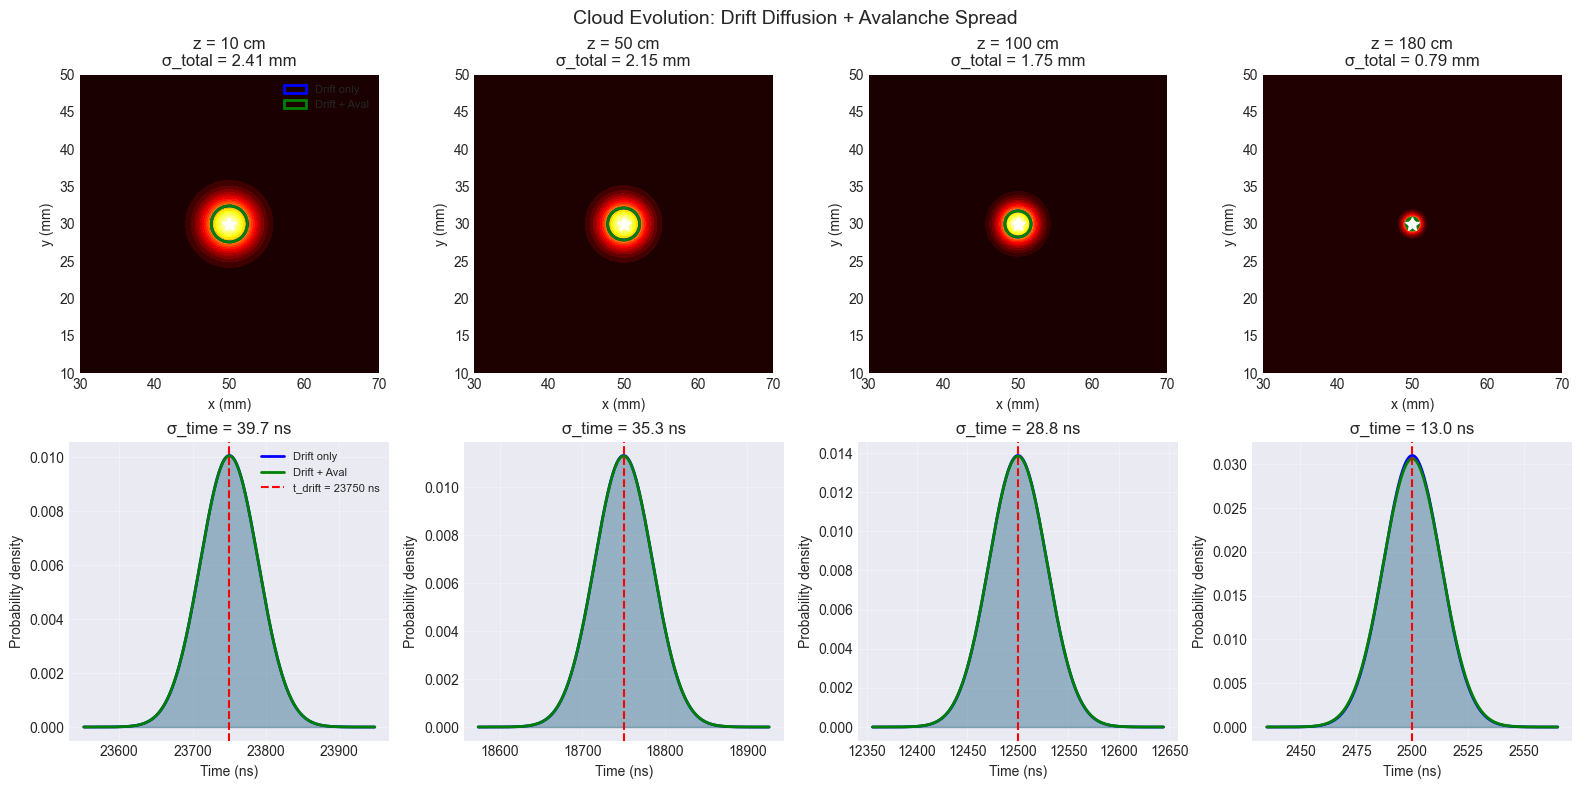

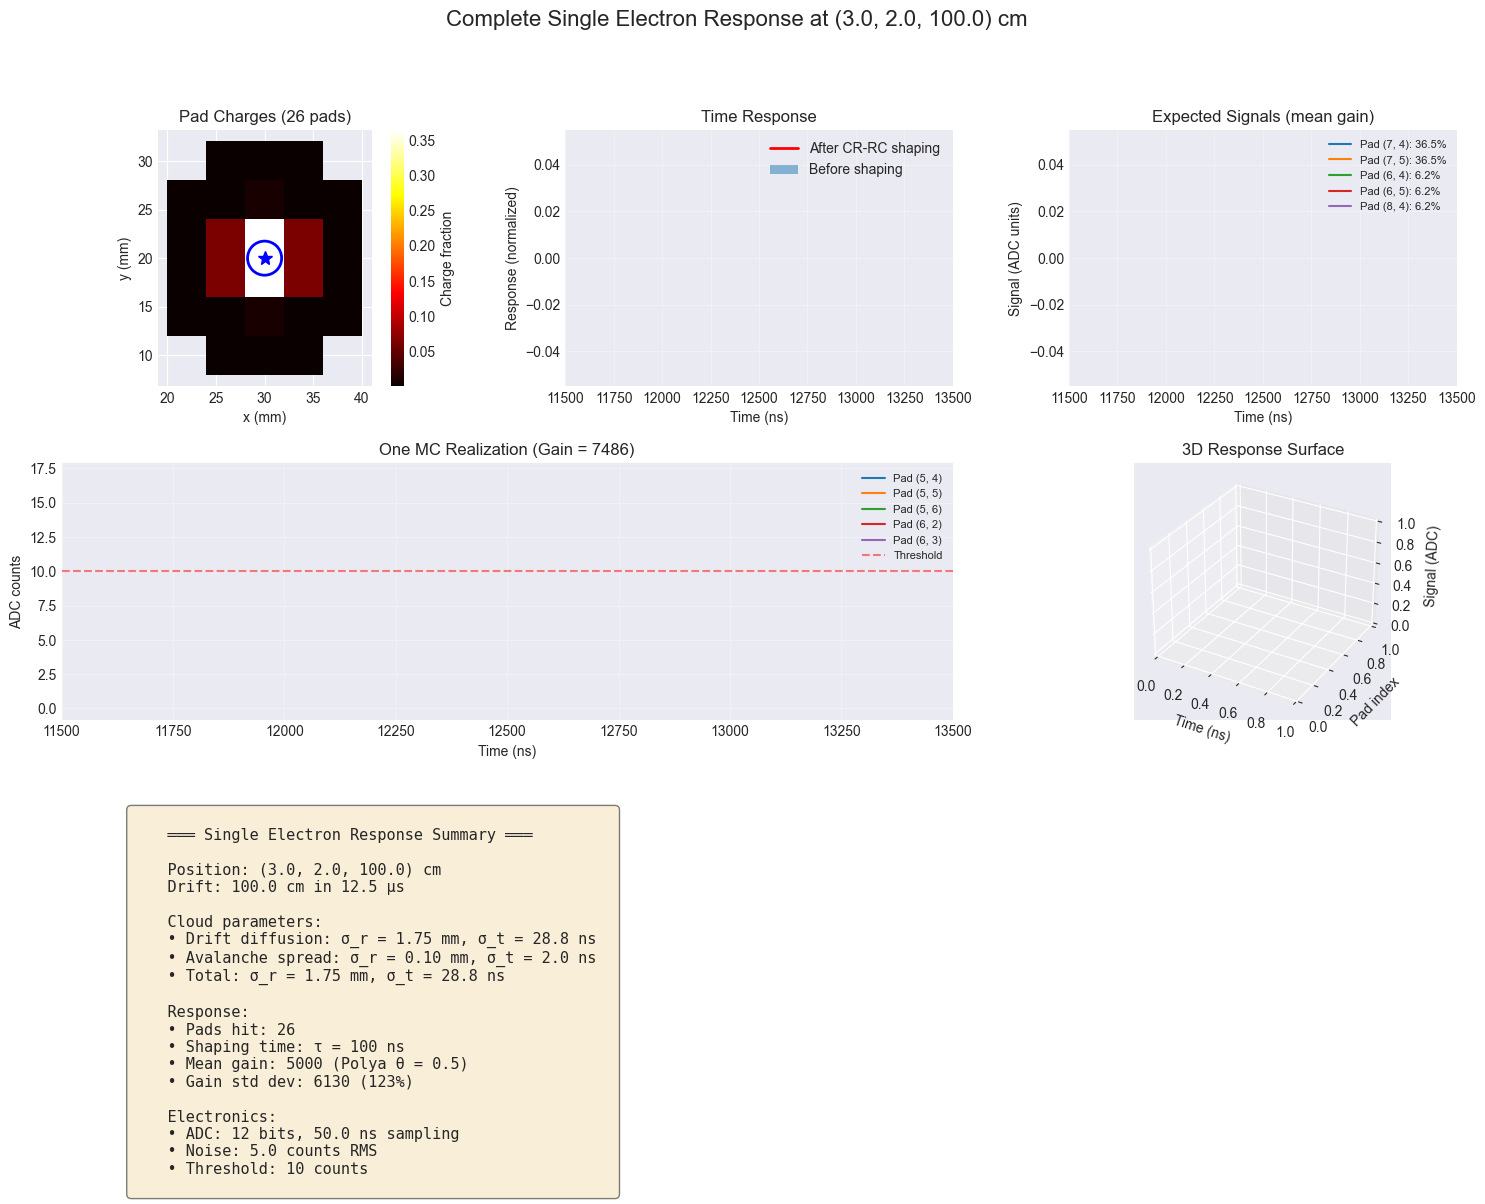

In [29]:
if __name__ == "__main__":
    print("═══ Complete TPC Single Electron Response ═══\n")
    
    # 1. Show cloud evolution
    print("1. Generating cloud evolution plot...")
    fig1 = visualize_cloud_evolution()
    
    # 2. Complete response for one electron
    print("2. Generating complete response visualization...")
    fig2 = visualize_complete_response(x0=3.0, y0=2.0, z0=100.0)